# Time Series Analysis and Prediction with DARTS in Python

**Notebook Objective:** This notebook's objective is to decompose, analyze, fit and predict next months of the 30-years Mortgage rates in the USA.

**Packages:** Pandas, Numpy, Matplotlib, DARTS 

## Imports

In [804]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
import darts.utils.statistics as dstats
from darts.models import TBATS, AutoARIMA, ExponentialSmoothing, Theta
from darts.utils.utils import ModelMode
from darts.metrics import mape


## Datasets

In [836]:
# Load data
df = pd.read_csv('../.data/mortgage_rates.csv', parse_dates=['dt'])
df = df.query('dt >= "2019-01-01"').reset_index(drop=True)


# Load inflation rates
inflation = pd.read_csv('../.data/inflation_rates.csv', parse_dates=['dt'])
inflation = inflation.query('dt >= "2019-01-01"').reset_index(drop=True)

# Make them data a Darts Time Series object
series = TimeSeries.from_dataframe(df, 'dt', freq='ME')
series2= TimeSeries.from_dataframe(inflation, 'dt', freq='ME')


In [837]:
# Train and Validation split
train, val = series.split_after(0.75) # 75% train, 25% test

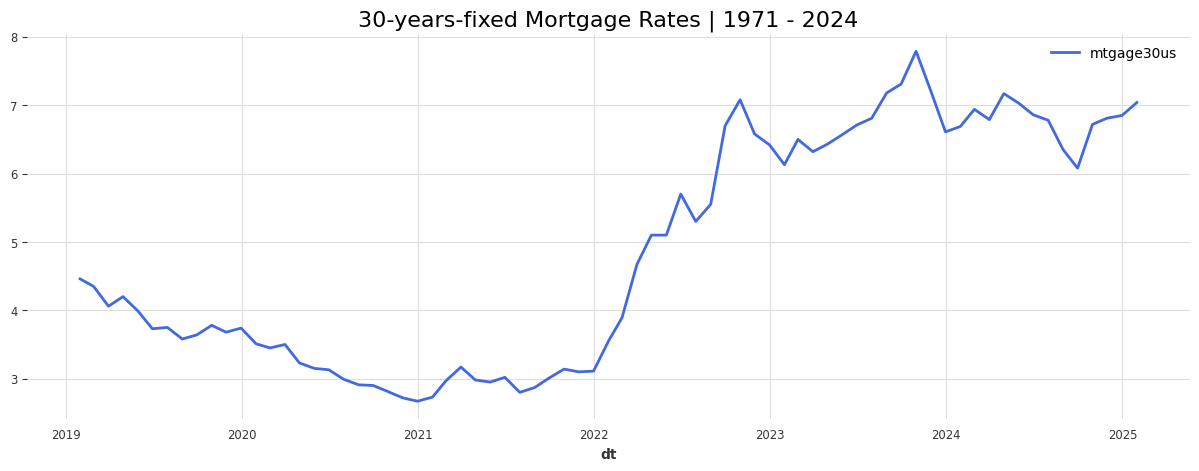

In [838]:
# View the Mortgage Rates series
plt.figure(figsize=(15,5))
series.plot(lw=2, color='royalblue')
plt.title('30-years-fixed Mortgage Rates | 1971 - 2024', size=16);

## Series Stationerity

In [839]:
# Checking if the series is autoregressive.
# We can do that with the ADF test
adf, p_value, n_lags, nobs, critical, icbest = dstats.stationarity_test_adf(series)
print(f" ADF:{adf} \n p_value:{p_value} \n Number of Lags used:{n_lags} \n Number of obs:{nobs}")
if p_value > 0.05: print(' The series is NOT Stationary') 
else: print(' Series IS Stationary')

 ADF:-1.1986999100700757 
 p_value:0.6741547275926428 
 Number of Lags used:12 
 Number of obs:60
 The series is NOT Stationary


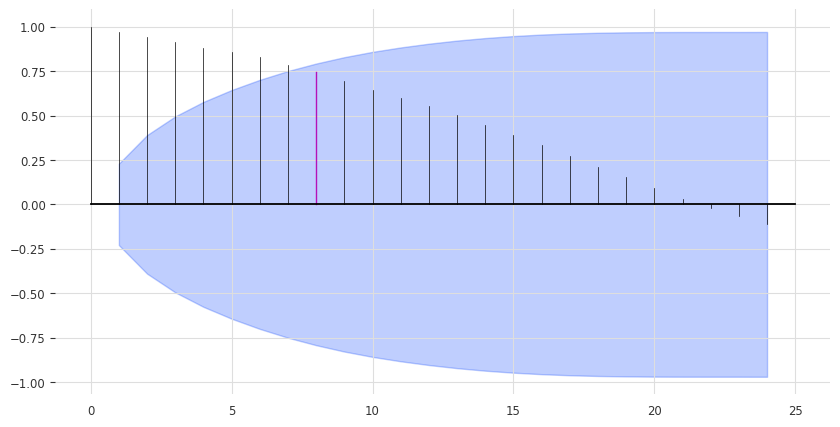

In [840]:
# Plot of the Auto-Correlation Function (ACF)
# When there's a gradual decline in the ACF plot, the series is not stationary (Peixeiro, 20222)
dstats.plot_acf(series,
                m=8, # you can choose an specific period to highlight
                alpha=0.05,
                max_lag=24)

In [841]:
# Checking Seasonality in any given periods from 1 to max_lag
dstats.check_seasonality(series,
                      max_lag=24,
                      alpha=0.05)

(False, 0)

In [847]:
# Checking if the differentiated series is autoregressive.
# We can do that with the ADF test
adf, p_value, n_lags, nobs, critical, icbest = dstats.stationarity_test_adf(series.diff(1))
print(f" ADF:{adf} \n p_value:{p_value} \n Number of Lags used:{n_lags} \n Number of obs:{nobs}")
if p_value > 0.05: print(' The series is NOT stationary') 
else: print(' Series IS stationary')

 ADF:-7.090536891955233 
 p_value:4.4221984321205906e-10 
 Number of Lags used:0 
 Number of obs:71
 Series IS stationary


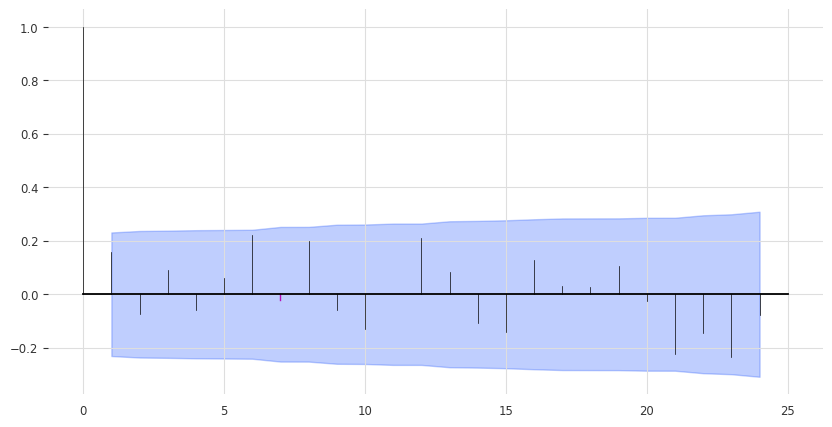

In [848]:
# ACF of the differentiated series
dstats.plot_acf(series.diff(1),
                m=7, # you can choose an specific period to highlight
                alpha=0.05,
                max_lag=24)

When there are no significant coefficients after lag 0. This is an indicator that we are dealing with a random walk [PEIXEIRO, 2022].

## Time Series Decomposition

A Time Series is composed of 3 components. 
* **Trend:** long-term movement, that can be up (when the numbers observed increase over time), or down (when the numbers observed decrease over time).
* **Seasonality:** seasonal pattern or the cycles that repeat over a period of time.
* **Residuals:** the behavior that cannot be explained by the other two components.

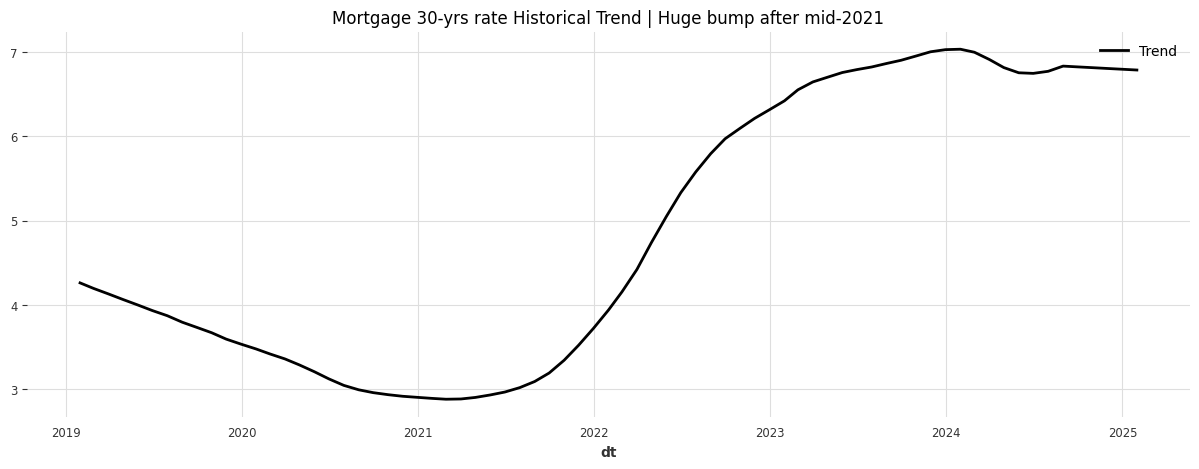

In [844]:
# Extract Trend and seasonality
trend, seasonality = dstats.extract_trend_and_seasonality(series, 12)

# Plot Trend
plt.figure(figsize=(15,5))
trend.plot(label='Trend')
plt.title('Mortgage 30-yrs rate Historical Trend | Huge bump after mid-2021');

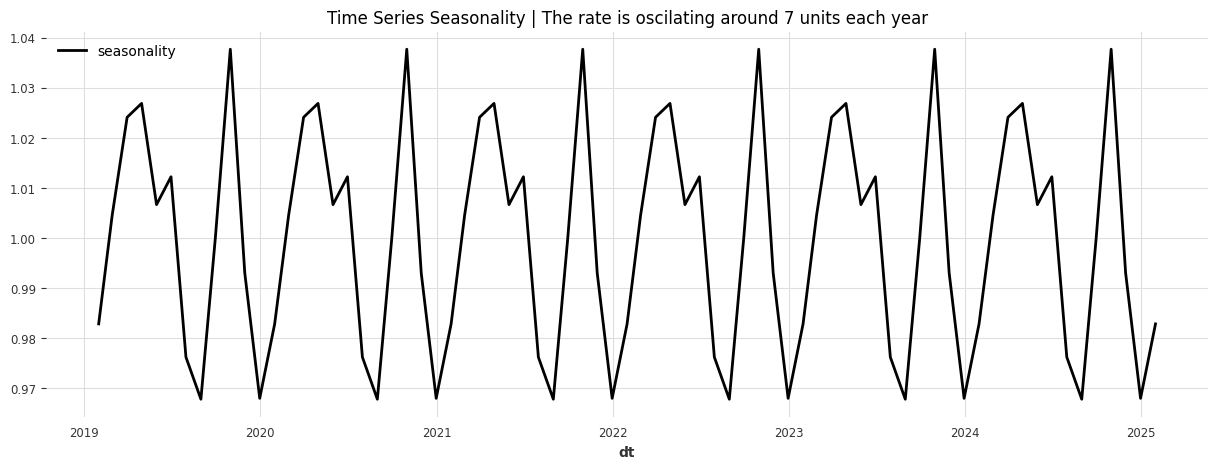

In [845]:
# Plot seasonality
plt.figure(figsize=(15,5))
seasonality.plot(label='seasonality')
plt.title('Time Series Seasonality | The rate is oscilating around 7 units each year');

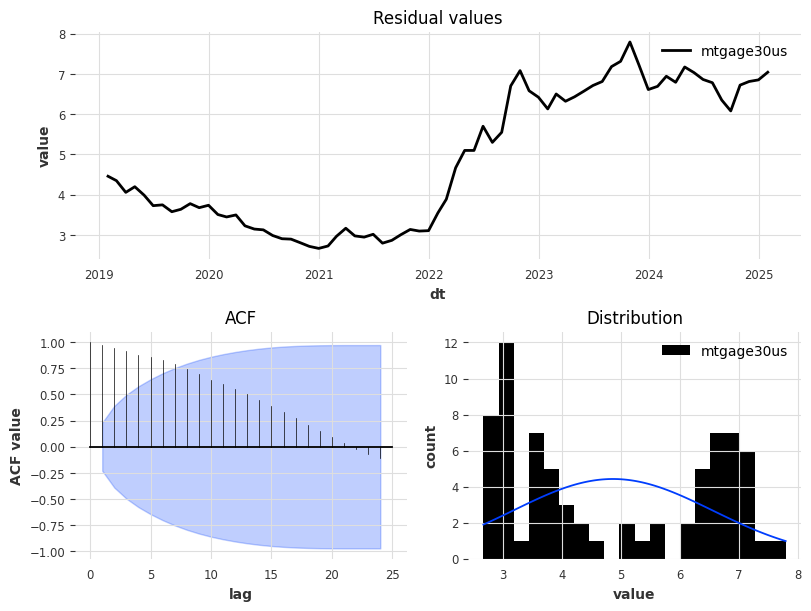

In [846]:
# Check the residuals of the data
dstats.plot_residuals_analysis(series)

## Modeling

Darts is built to make it easy to train and validate several models in a unified way. Let’s train a few more and compute their respective MAPE on the validation set.

In [853]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%")


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 18.72%
model TBATS() obtains MAPE: 23.32%
model AutoARIMA() obtains MAPE: 15.62%
model Theta() obtains MAPE: 6.07%


### Exponential Smooth

MAPE Exponential Smooth model: 23.65%


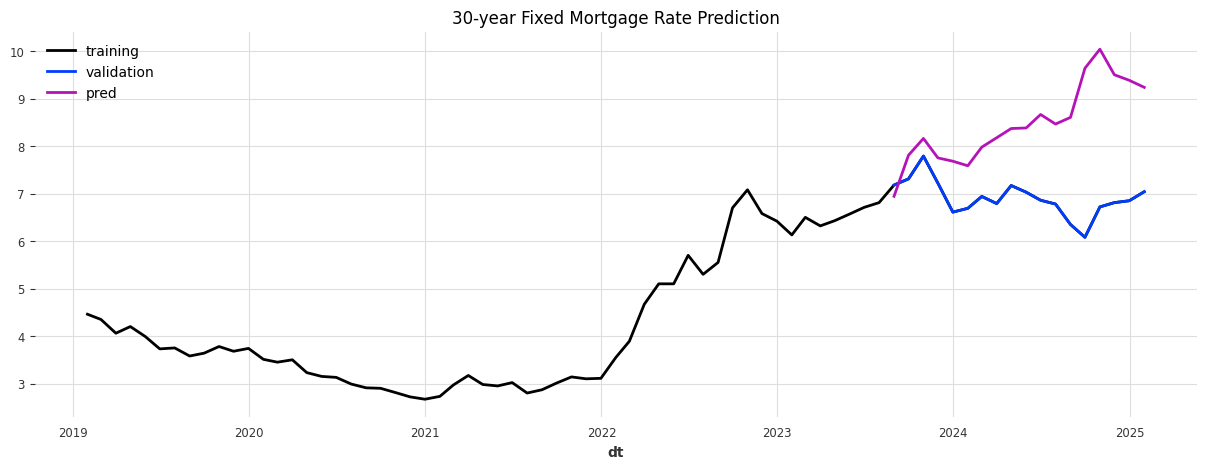

In [857]:
# Fit and Predict
model = ExponentialSmoothing(trend= ModelMode.ADDITIVE, seasonal=ModelMode.MULTIPLICATIVE, seasonal_periods=12)
model.fit(train)
prediction = model.predict(len(val))

print(f'MAPE Exponential Smooth model: {np.round(mape(val, prediction),2)}%')

# Plot
plt.figure(figsize=(15,5))
series.plot(label="training")
val.plot(label="validation")
prediction.plot(label='pred', low_quantile=0.95, high_quantile=0.95)
plt.title('30-year Fixed Mortgage Rate Prediction')
plt.legend(); #used to show the confidence interval

### Theta Model

In [863]:
for theta in np.arange(0.05, 2, 0.1):
    # define some boundaries for the parameters
    m_theta = Theta(theta=theta, seasonality_period=12)
    m_theta.fit(train)
    pred = m_theta.predict(len(val))
    print(f"model {m_theta} obtains MAPE: {mape(val, pred):.2f}%")

model Theta(theta=0.05, seasonality_period=12) obtains MAPE: 149.84%
model Theta(theta=0.15000000000000002, seasonality_period=12) obtains MAPE: 41.96%
model Theta(theta=0.25000000000000006, seasonality_period=12) obtains MAPE: 20.38%
model Theta(theta=0.35000000000000003, seasonality_period=12) obtains MAPE: 11.13%
model Theta(theta=0.45000000000000007, seasonality_period=12) obtains MAPE: 6.50%
model Theta(theta=0.5500000000000002, seasonality_period=12) obtains MAPE: 4.54%
model Theta(theta=0.6500000000000001, seasonality_period=12) obtains MAPE: 4.06%
model Theta(theta=0.7500000000000002, seasonality_period=12) obtains MAPE: 3.89%
model Theta(theta=0.8500000000000002, seasonality_period=12) obtains MAPE: 4.09%
model Theta(theta=0.9500000000000002, seasonality_period=12) obtains MAPE: 4.54%
model Theta(theta=1.0500000000000003, seasonality_period=12) obtains MAPE: 5.26%
model Theta(theta=1.1500000000000004, seasonality_period=12) obtains MAPE: 5.88%
model Theta(theta=1.2500000000000

MAPE Theta(theta=0.75, seasonality_period=12) Model: 3.89%


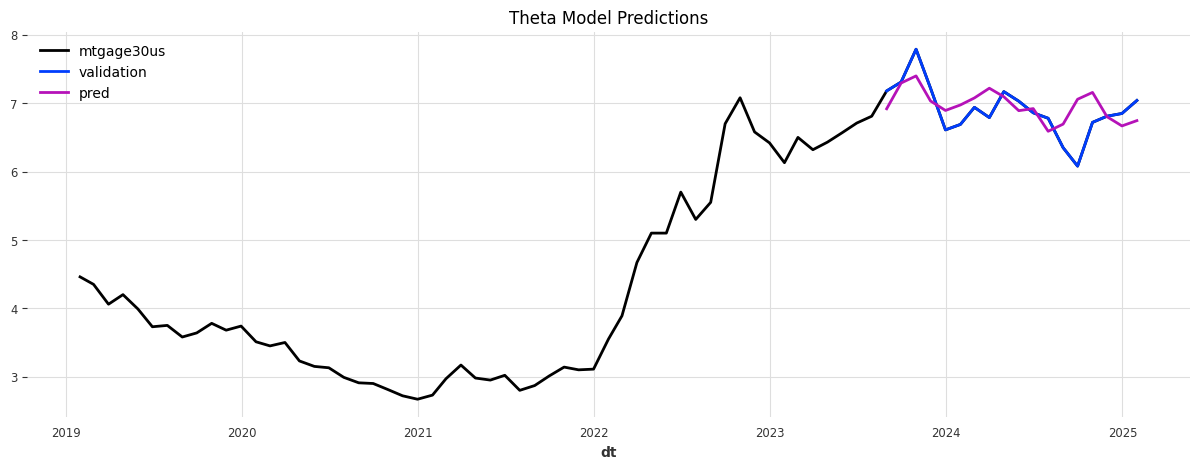

In [868]:
# define some boundaries for the parameters
m_theta = Theta(theta=0.75, seasonality_period=12)
m_theta.fit(train)
pred = m_theta.predict(len(val))

# Plot
plt.figure(figsize=(15,5))
series.plot()
val.plot(label="validation")
pred.plot(label='pred')
plt.title('Theta Model Predictions')
print(f"MAPE {m_theta} Model: {mape(val, pred):.2f}%");

In [ ]:
pd.DataFrame({
    'validation': val.values().flatten(),
    'prediction': pred.values().flatten(),
})

### TBATS Model

MAPE: 23.32%


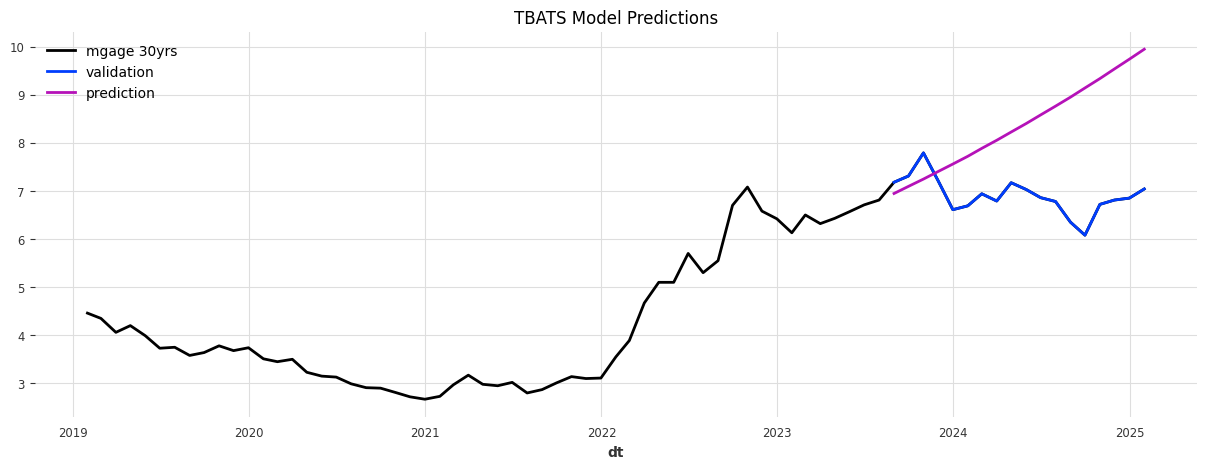

In [877]:
# Model with TBATS
tbats = TBATS(use_box_cox=True,
              use_trend=True,
              seasonal_periods=[12])

# Fit
tbats.fit(train)

# Predict
preds = tbats.predict(len(val))

# MAPE
print(f'MAPE TBATS: {round(mape(val, preds),2)}%')

# Plots
plt.figure(figsize=(15,5))
series.plot(label='mgage 30yrs')
val.plot(label='validation')
preds.plot(label='prediction', low_quantile=0.05, high_quantile=0.95)
plt.title('TBATS Model Predictions')
plt.legend();


### Auto Arima

MAPE ARIMA Model: 15.62%


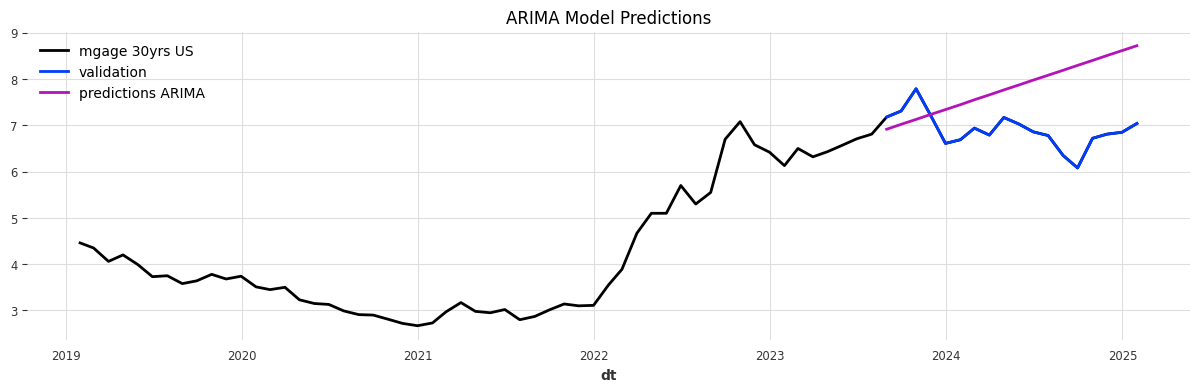

In [880]:
# Arima model
arima = AutoARIMA()

# Fit
arima.fit(train)

# Predict
preds = arima.predict(len(val))

# Result
print(f'MAPE ARIMA Model: {round(mape(val, preds),2)}%')

# Plot
plt.figure(figsize=(15,4))
series.plot(label='mgage 30yrs US')
val.plot(label='validation')
preds.plot(label='predictions ARIMA')
plt.title('ARIMA Model Predictions')
plt.legend();

## Backtesting
Backtesting simulates predictions that would have been obtained historically with a given model. 

Such simulated forecasts are always defined with respect to a forecast horizon, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 3 months into the future (compared to prediction time). The result of calling historical_forecasts() is (by default) a TimeSeries which contains only the last predicted value of each of those 3-months ahead forecasts

MAPE = 4.28%


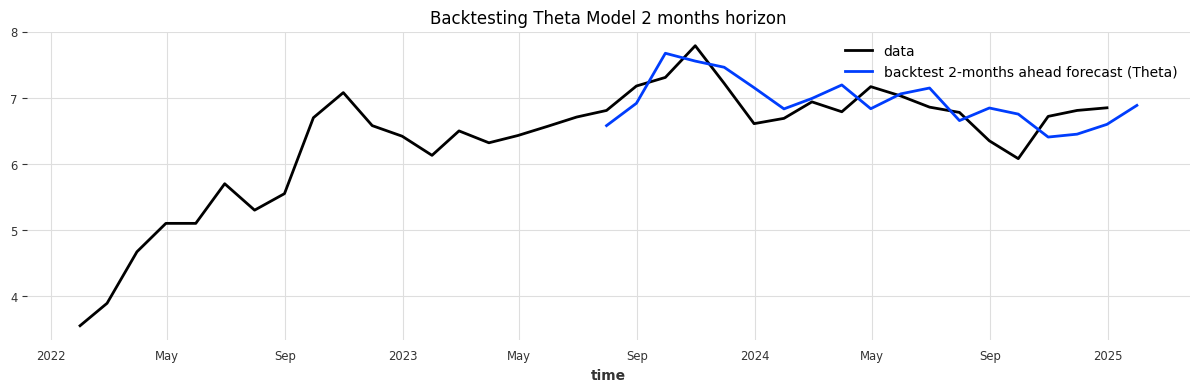

In [975]:
# Set parameters
hfc_params = {
    "series": series,
    "start": 0.75, #75% data to train. Can also be a timestamp of the break: pd.Timestamp("2022-10-01")
    "forecast_horizon": 1,
    "verbose": False,
}

# Train Backtesting
historical_fcast_theta = m_theta.historical_forecasts(
    last_points_only=True, 
    **hfc_params
)

# Plot
plt.figure(figsize=(15,4))
series.slice(start_ts=pd.Timestamp('2022-01-01'),
             end_ts=pd.Timestamp('2024-12-31')).plot(label="data")
historical_fcast_theta.plot(label="backtest 2-months ahead forecast (Theta)")
plt.title('Backtesting Theta Model 2 months horizon')
print(f"MAPE = {mape(series, historical_fcast_theta):.2f}%")

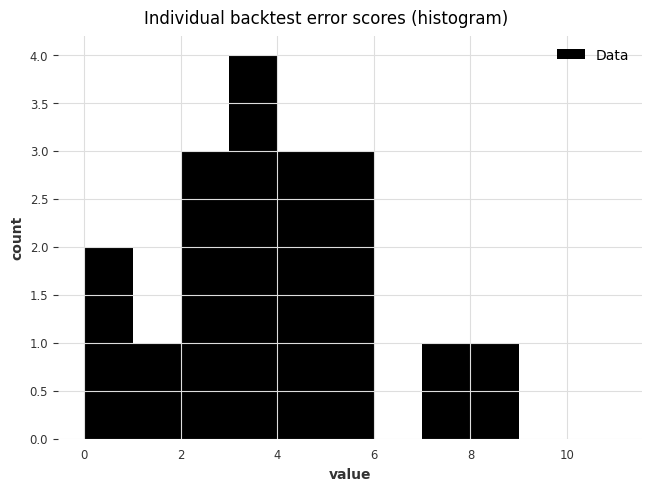

In [990]:
from darts.utils.statistics import plot_hist

# Calculate raw MAPE errors
raw_errors = m_theta.backtest(
    metric=mape, 
    reduction=None,
    last_points_only=False,
    **hfc_params )

# Plot histogram
plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
);

In [996]:
# Backtest's average MAPE error
average_error = m_theta.backtest(
    metric=mape,
    reduction=np.mean,  # this is actually the default
    **hfc_params,
)

print(f"Average error (MAPE) over all historical forecasts: {average_error:.2f}%")

Average error (MAPE) over all historical forecasts: 4.28%


### Predictions Thetha Model

What happens if we predict 2025 first 6 months?

Values Forecasted: [7.17357616 7.29093601 7.28817669 7.12257253 7.13979163 6.86417525
 6.78388242 6.9881581 ]


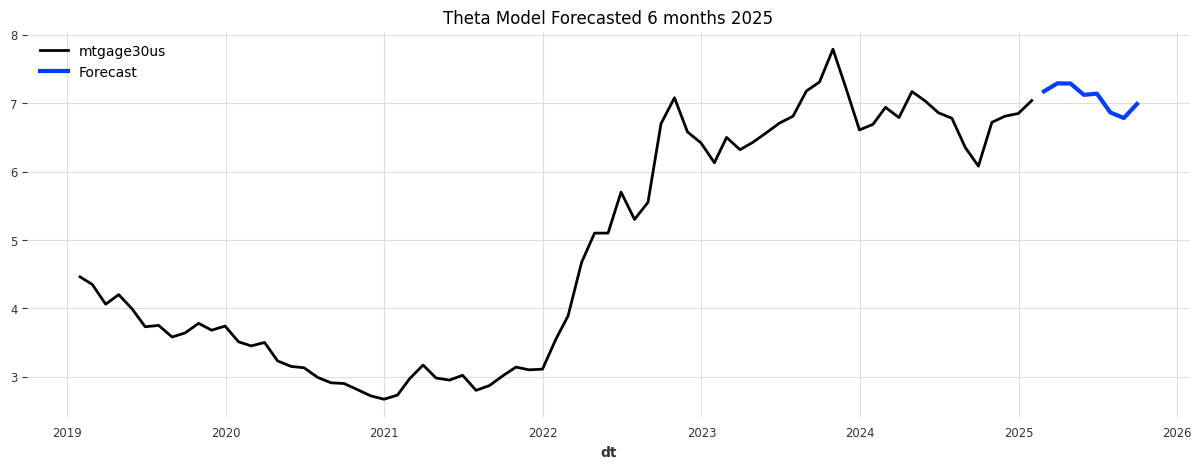

In [997]:
from darts.utils.utils import SeasonalityMode

# Predicting first 6 months' rates of 2025
m_theta = Theta(theta=0.75, seasonality_period=12, 
                season_mode=SeasonalityMode.MULTIPLICATIVE)

# Fit model to the entire series
m_theta.fit(series)

# Predict next 6 months
forecast_6mths = m_theta.predict(8)

# Plot
plt.figure(figsize=(15,5))
series.plot()
forecast_6mths.plot(label="Forecast", lw=3)
plt.title('Theta Model Forecasted 6 months 2025')
plt.legend();

print(f'Values Forecasted: {forecast_6mths.values().flatten()}')


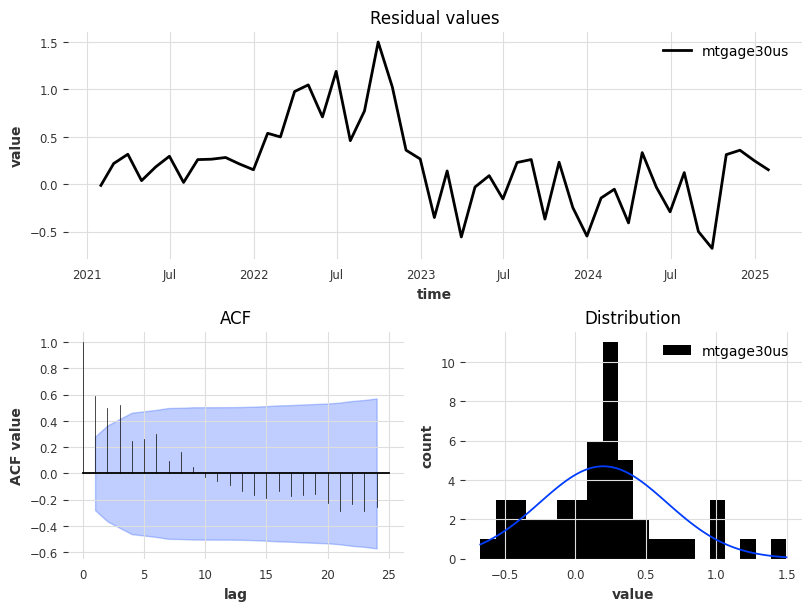

In [919]:
# Check residuals
dstats.plot_residuals_analysis(m_theta.residuals(series))

Analyzing the errors of this model, we notice that it is much less biased than the initial residuals plot that we created. This is confirmed because the histogram data is somewhat more centered around 0 than before.